In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
database_path = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f1455fdb38>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08}

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

1 year of data starts on: 2016-08-23


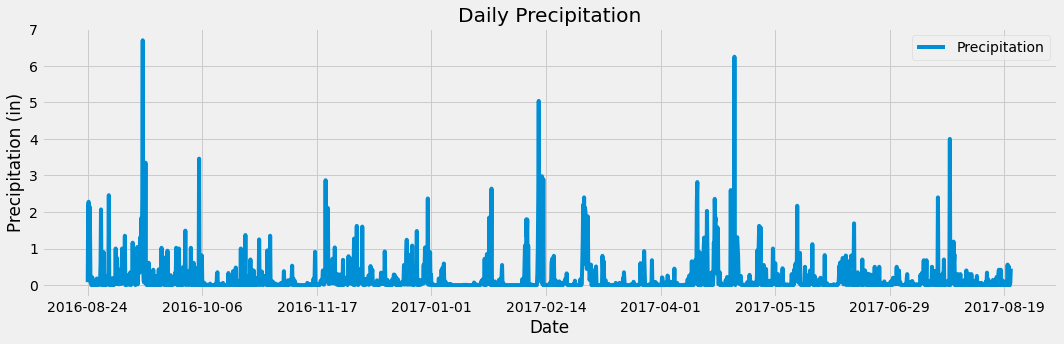

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("1 year of data starts on:", year_ago)
# Perform a query to retrieve the data and precipitation scores
session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column and order by date
precip_data = pd.DataFrame(session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > year_ago).\
    order_by(measurement.date).all(), columns=['date', 'prcp'])\
    .set_index('date').dropna()

#Use Pandas Plotting with Matplotlib to plot the data
precip_plot = precip_data.plot(figsize=(15, 5))
precip_plot.set_title('Daily Precipitation')
precip_plot.set_ylabel('Precipitation (in)')
precip_plot.set_xlabel('Date')
precip_plot.legend(['Precipitation'], loc='best')
plt.tight_layout()
plt.savefig('Images/Daily Precipitation.png')
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
session.query(station.station).count()

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#Minimum temp @ USC00519281
min_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f'The minimum temperature observed at station USC00519281 was {min_temp[0][0]} degrees.')

#Maximum temp @ USC00519281
max_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f'The maximum temperature observed at station USC00519281 was {max_temp[0][0]} degrees.')

#Average temp @ USC00519281
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f'The average temperature observed at station USC00519281 was {round(avg_temp[0][0], 1)} degrees.')

The minimum temperature observed at station USC00519281 was 54.0 degrees.
The maximum temperature observed at station USC00519281 was 54.0 degrees.
The average temperature observed at station USC00519281 was 71.7 degrees.


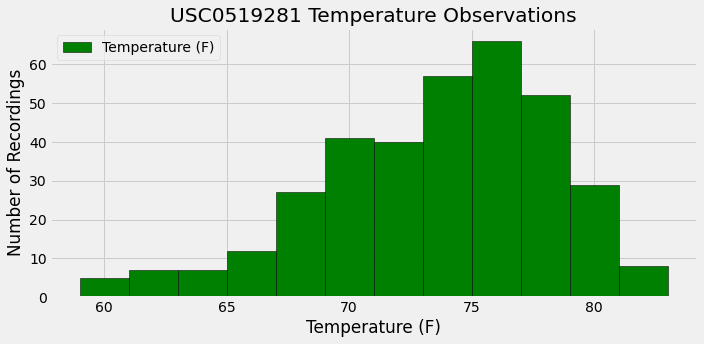

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = pd.DataFrame(session.query(measurement.date, measurement.tobs).\
    filter(measurement.date > year_ago).\
    filter(measurement.station == 'USC00519281').\
    order_by(measurement.date).all(), columns=['date', 'tobs']).set_index('date').dropna()
temp_plot = temp_data.plot(kind='hist', edgecolor = 'black', color = 'green', figsize=(10,5), bins=12)
temp_plot.set_title('USC0519281 Temperature Observations')
temp_plot.set_ylabel('Number of Recordings')
temp_plot.set_xlabel('Temperature (F)')
temp_plot.legend(['Temperature (F)'], loc='upper left')
plt.tight_layout()
plt.savefig('Images/USC00519281 Temp Histogram.png')
plt.show()

# Close session

In [16]:
# Close Session
session.close()